In [1]:
import os
if os.path.exists("/gss_gpfs_scratch/"):
    RMG_PY_PATH = os.path.expanduser('/gss_gpfs_scratch/westgroup/Importer/RMG-Py/')
    RMG_MODELS_PATH = os.path.expanduser('/gss_gpfs_scratch/westgroup/Importer/RMG-models')
else:
    RMG_PY_PATH = os.path.expanduser('~/Code/RMG-discovery/')
    RMG_MODELS_PATH = os.path.expanduser('~/Code/RMG-models')

In [2]:
import IPython
from IPython.display import display
import sys
import os
import re

sys.path.insert(1,RMG_PY_PATH) # a copy of RMG-Py on the `importer` branch.
from rmgpy.molecule import Molecule
import rmgpy.kinetics
import numpy
import cPickle as pickle
from collections import Counter, defaultdict
from rmgpy.reaction import Reaction
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import rmgpy.rmg
import rmgpy.data
import rmgpy.data.kinetics
import ck2cti
import numpy as np
import matplotlib.pyplot as plt

# This is an ipython notebook to process the results from running `sarathy_comparison.py` and `heptane_comparison.py`

### This is importing the ignition delays

In [3]:
import cPickle as pickle
import pandas as pd
f = open("../reference_files/ignition_delay_heptane.pkl", "r")
heptane_data = pickle.load(f)
print heptane_data.shape
g = open("../reference_files/ignition_delay_sarathy.pkl", "r")
sarathy_data = pickle.load(g)
print sarathy_data.shape

(16, 118)
(16, 56)


### This is getting the species dictionaries for each model

In [4]:
master = 'CombFlame2012/2028-Sarathy'
# Find and read the chemkin file
with open(os.path.join(RMG_MODELS_PATH, master,'import.sh')) as infile:
    shellscript = infile.read()
reactions_filename = re.search('--reactions\s+(\S+)',shellscript).group(1)
reactions_filepath = os.path.join(RMG_MODELS_PATH,master,reactions_filename)
thermo_filename = re.search('--thermo\s+(\S+)',shellscript).group(1)
thermo_filepath = os.path.join(RMG_MODELS_PATH,master,thermo_filename)
print(reactions_filepath)
print(thermo_filepath)
with open(reactions_filepath) as infile:
    chemkin = infile.readlines()
#for i,line in enumerate(chemkin):
    #print i, line.strip()             # uncomment to print the chemkin model
    
print "".join(chemkin[:4]) # print first 4 lines only

sarathy_parser = ck2cti.Parser()
surfaces = sarathy_parser.convertMech(inputFile=reactions_filepath,
                              thermoFile=thermo_filepath,
                              transportFile=None,
                              surfaceFile=None,
                              phaseName=None,
                              outName='sarathy_master.cti',
                              permissive=True)
sarathy_parser.reactions[0]

dict_path = os.path.join(RMG_MODELS_PATH, master, 'RMG-Py-kinetics-library', 'dictionary.txt')
print "Loading species_dict from",dict_path
sarathy_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies(dict_path)

oh*<=>oh+hv                                  1.450e+06      0.0           0.0
If the "--permissive" option was specified, this will be converted to an irreversible reaction with the photon removed.
ch*<=>ch+hv 1.860e+06 0.0 0.0
If the "--permissive" option was specified, this will be converted to an irreversible reaction with the photon removed.


/Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/model.txt
/Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/thermo.txt
!A comprehensive chemical kinetic combustion model for the four butanol isomers
!S.M. Sarathy, S. Vranckx, K. Yasunaga, M. Mehl, P. O�wald, W.K. Metcalfe,
!C. K. Westbrook, W.J. Pitz, K. Kohse-Hoinghaus, R.X. Fernandes, H.J Curran
!  Accepted Combustion and Flame, Dec 2011



INFO:root:Skipping unexpected species "hoco" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3cho2h" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3coch2o2h" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3coch2o" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3chcho" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c3h2" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h11-1" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h11-2" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h11-3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h10-1" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h10-2" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h81-3" while reading thermodynami

Wrote CTI mechanism file to 'sarathy_master.cti'.
Mechanism contains 431 species and 2346 reactions.
Loading species_dict from /Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/RMG-Py-kinetics-library/dictionary.txt


In [5]:
master = 'n-Heptane'
# Find and read the chemkin file
with open(os.path.join(RMG_MODELS_PATH, master,'import.sh')) as infile:
    shellscript = infile.read()
reactions_filename = re.search('--reactions\s+(\S+)',shellscript).group(1)
reactions_filepath = os.path.join(RMG_MODELS_PATH,master,reactions_filename)
thermo_filename = re.search('--thermo\s+(\S+)',shellscript).group(1)
thermo_filepath = os.path.join(RMG_MODELS_PATH,master,thermo_filename)
print(reactions_filepath)
print(thermo_filepath)
with open(reactions_filepath) as infile:
    chemkin = infile.readlines()
#for i,line in enumerate(chemkin):
    #print i, line.strip()             # uncomment to print the chemkin model
    
print "".join(chemkin[:4]) # print first 4 lines only

heptane_parser = ck2cti.Parser()
surfaces = heptane_parser.convertMech(inputFile=reactions_filepath,
                              thermoFile=thermo_filepath,
                              transportFile=None,
                              surfaceFile=None,
                              phaseName=None,
                              outName='sarathy_master.cti',
                              permissive=True)


dict_path = os.path.join(RMG_MODELS_PATH, master, 'RMG-Py-kinetics-library', 'dictionary.txt')
print "Loading species_dict from",dict_path
heptane_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies(dict_path)


/Users/nathan/Code/RMG-models/n-Heptane/nc7_ver3.1_mech.txt
/Users/nathan/Code/RMG-models/n-Heptane/n_heptane_v3.1_therm.dat
!n-heptane mechanism ver. 3.1 2012-03-30
!M. Mehl, W. J. Pitz, C. K. Westbrook and H. J. Curran, "Kinetic Modeling of Gasoline Surrogate Components and Mixtures under Engine Conditions," Proc. Combust. Inst.  33 (1) (2011) 193-200.
!LLNL-MI-536391
!March 2012: Multiplied the A-factors of the molecular elimination of HO2 from heptyl-O2 by a factor of 2. The previous version reported lower values doe to a clerical error in the uploaded file.



INFO:root:Skipping unexpected species "HOCO" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3CHO2H" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3CHCHO" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C3H51-2V3OOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C3H52-1V3OOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "IC5H12" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "AC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "BC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "DC5H11" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "AC5H10" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "BC5H10" while reading thermodynami

Wrote CTI mechanism file to 'sarathy_master.cti'.
Mechanism contains 654 species and 4846 reactions.
Loading species_dict from /Users/nathan/Code/RMG-models/n-Heptane/RMG-Py-kinetics-library/dictionary.txt


In [6]:
print "These are the errors for Sarathy model swaps"
from copy import deepcopy
test_data = deepcopy(sarathy_data)
test_data = test_data[test_data.apply(np.isfinite)].apply(np.log10)
data = test_data["0"][test_data['0'].apply(np.isfinite)].apply
temps = test_data["0"][test_data['0'].apply(np.isfinite)].index



sarathy_results = []
for col in test_data.columns:
    
    if col == "0":
        continue 
        
    variation_data = test_data[col]
    print sarathy_parser.reactions[int(col)]
    
    i = 0
    E_sum = 0.0
    
    for temp in temps:
        log_delay = test_data[col].loc[temp]
        sarathy_delay = test_data['0'].loc[temp]
        i +=1
        E_sum += abs(sarathy_delay - log_delay)
        
        i +=1
        
    E_sum = E_sum / i
        
    
    sarathy_results.append([col, E_sum])
    
        
    print "For reaction {0} the error is {1}".format(col, E_sum)
    
    print

These are the errors for Sarathy model swaps
c2h5coch3 + o <=> ch2ch2coch3 + oh
For reaction 1150 the error is 6.92972546642e-05

ic4h8oh-2o2 + h2o2 <=> ic4h8oh-2o2h + ho2
For reaction 2105 the error is 4.42072089524e-05

nc4h9oh + ch3 <=> c4h8oh-4 + ch4
For reaction 1568 the error is 0.000102235700588

nc3h7cho + ho2 <=> c3h6cho-2 + h2o2
For reaction 1194 the error is 4.68962934308e-05

nc3h7cho + ch3 <=> nc3h7co + ch4
For reaction 1187 the error is 0.00041480400085

c2h6 + ch3o2 <=> c2h5 + ch3o2h
For reaction 196 the error is 0.000141752217814

ch2o + oh <=> hoch2o
For reaction 77 the error is 0.00639727906527

c2h5oh + ho2 <=> pc2h4oh + h2o2
For reaction 369 the error is 5.43663823429e-05

ch3och3 + ch3o2 <=> ch3och2 + ch3o2h
For reaction 435 the error is 4.32623854213e-05

ic4h8oh-3o2 + h2o2 <=> ic4h8oh-3o2h + ho2
For reaction 2106 the error is 4.28381320256e-05

pc4h9o2 + pc4h9o2 -> o2 + pc4h9o + pc4h9o
For reaction 1081 the error is 3.22710226016e-05

sc4h9oh + ho2 <=> sc4h8oh-3 

In [7]:
sarathy_results = pd.DataFrame(sarathy_results)
sarathy_results.columns = ["Reaction Index", "Sarathy Error"]
sarathy_results = sarathy_results.set_index("Reaction Index")
sarathy_results

,Sarathy Error
Reaction Index,
1150,0.000069
2105,0.000044
1568,0.000102
1194,0.000047
1187,0.000415
196,0.000142
77,0.006397
369,0.000054
435,0.000043


In [8]:
print "These are the errors for the Heptane model swaps"
from copy import deepcopy
test_data = deepcopy(heptane_data)
test_data = test_data[test_data.apply(np.isfinite)].apply(np.log10)
data = test_data["0"][test_data['0'].apply(np.isfinite)]
temps = test_data["0"][test_data['0'].apply(np.isfinite)].index

heptane_results = []
for col in test_data.columns:
    
    if col == "0":
        continue 
        
    variation_data = test_data[col]
    
    i = 0
    E_sum = 0.0
    
    for temp in temps:
        log_delay = test_data[col].loc[temp]
        heptane_delay = test_data['0'].loc[temp]
        i +=1
        E_sum += abs(heptane_delay - log_delay)
        
        i +=1
        
    E_sum = E_sum / i
    
    heptane_results.append([col, E_sum])
    
        
    print "For reaction {0} the error is {1}".format(col, E_sum)
    
    print

These are the errors for the Heptane model swaps
For reaction 1285 the error is 1.6137108772e-05

For reaction 2637 the error is 5.95544913926e-06

For reaction 3486 the error is 1.27935634321e-06

For reaction 2493 the error is 2.66785835112e-06

For reaction 2195 the error is 2.33768484214e-06

For reaction 3573 the error is 8.36854092136e-07

For reaction 3621 the error is 0.000417218416217

For reaction 2591 the error is 5.73680557979e-05

For reaction 285 the error is 0.000167070058457

For reaction 105 the error is 3.14207750394e-05

For reaction 2957 the error is 1.15705459581e-06

For reaction 4350 the error is 1.93320373551e-06

For reaction 33 the error is 0.000387761132053

For reaction 2062 the error is 1.15256705587e-06

For reaction 2494 the error is 2.55991345283e-06

For reaction 2760 the error is 2.54233454316e-06

For reaction 86 the error is 0.00412178642937

For reaction 1726 the error is 3.22960652815e-06

For reaction 4112 the error is 1.94776553981e-05

For react

In [9]:
heptane_results = pd.DataFrame(heptane_results)
heptane_results.columns = ["Reaction Index", "Heptane Error"]
heptane_results = heptane_results.set_index("Reaction Index")
heptane_results

,Heptane Error
Reaction Index,
1285,1.613711e-05
2637,5.955449e-06
3486,1.279356e-06
2493,2.667858e-06
2195,2.337685e-06
3573,8.368541e-07
3621,4.172184e-04
2591,5.736806e-05
285,1.670701e-04


In [10]:
import matplotlib.pyplot as plt

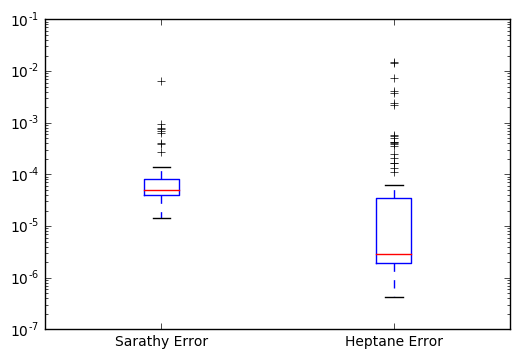

In [11]:
results = pd.concat([sarathy_results, heptane_results], axis=1)
_, bp = results.plot.box(return_type='both', logy=True)

outliers = [flier.get_ydata() for flier in bp["fliers"]]
sarathy_outliers = outliers[0]
heptane_outliers = outliers[1]

In [12]:
print "The following reactions in the HEPTANE MODEL are outliers based on our error metric"

# pulled this reactions by hand because of some indexing error that happened with the parser

sarathy_77 = "reaction('ch2o + ho2 <=> h2o2 + hco', [4.257000e-06, 5.203, (5.0981, 'kcal/mol')])"
sarathy_22 = "reaction('h2o2 + h <=> h2 + ho2', [1.651000e+02, 3.267, (1.016, 'kcal/mol')])"


sarathy_results[(sarathy_results.values == sarathy_outliers)].sort_values("Sarathy Error", ascending=False)

The following reactions in the HEPTANE MODEL are outliers based on our error metric


,Sarathy Error
Reaction Index,
77,0.006397
410,0.000945
1564,0.000781
1566,0.000773
252,0.000693
1565,0.000629
1187,0.000415
552,0.000387
22,0.000275


In [13]:
print "The following reactions in the HEPTANE MODEL are outliers based on our error metric"
heptane_3622 = "reaction('HO2 + NC7H16 <=> C7H15-2 + H2O2', [5.470000e-04, 4.568, (11.6548, 'kcal/mol')])"
heptane_893 = "reaction('C3H5-A + H2O2 <=> C3H6 + HO2', [5.506000e-07, 5.123, (4.6781, 'kcal/mol')])"
heptane_results[(heptane_results.values == heptane_outliers)].sort_values("Heptane Error", ascending=False)

The following reactions in the HEPTANE MODEL are outliers based on our error metric


,Heptane Error
Reaction Index,
3622,0.015122
3624,0.014657
3626,0.007452
86,0.004122
3620,0.003839
3623,0.002421
87,0.002196
392,0.000589
892,0.000559


## The Sarathy reaction with the lowest error is as follows:

In [14]:
rxn = sarathy_parser.reactions[21]
print rxn
r1, r2 = rxn.reactants
p1, p2 = rxn.products
s1 = r1[1]
s2 = r2[1]
s3 = p1[1]
s4 = p2[1]

sar_0 = Reaction(
    reactants = [sarathy_dict[s1.label], sarathy_dict[s2.label]], 
    products= [sarathy_dict[s3.label], sarathy_dict[s4.label]],
    reversible = True) 

h2o2 + h <=> h2 + ho2


## The Sarathy reaction with the highest error is as follows

In [15]:
rxn = sarathy_parser.reactions[76]
print rxn
r1, r2 = rxn.reactants
p1, p2 = rxn.products
s1 = r1[1]
s2 = r2[1]
s3 = p1[1]
s4 = p2[1]

sar_1 = Reaction(
    reactants = [sarathy_dict[s1.label], sarathy_dict[s2.label]], 
    products= [sarathy_dict[s3.label], sarathy_dict[s4.label]],
    reversible = True) 

ch2o + ho2 <=> hco + h2o2


## The Heptane reaction with the lowest energy is as follows:

In [16]:
rxn = heptane_parser.reactions[892]
print rxn
r1, r2 = rxn.reactants
p1, p2 = rxn.products
s1 = r1[1]
s2 = r2[1]
s3 = p1[1]
s4 = p2[1]

hep_0 = Reaction(
    reactants = [heptane_dict[s1.label], heptane_dict[s2.label]], 
    products= [heptane_dict[s3.label], heptane_dict[s4.label]],
    reversible = True) 

C3H5-A + H2O2 -> C3H6 + HO2


## The Heptane reaction with the lowest energy is as follows:

In [17]:
rxn = heptane_parser.reactions[3621]
print rxn
r1, r2 = rxn.reactants
p1, p2 = rxn.products
s1 = r1[1]
s2 = r2[1]
s3 = p1[1]
s4 = p2[1]

hep_1 = Reaction(
    reactants = [heptane_dict[s1.label], heptane_dict[s2.label]], 
    products= [heptane_dict[s3.label], heptane_dict[s4.label]],
    reversible = True) 

NC7H16 + HO2 -> C7H15-2 + H2O2


In [22]:
important_sarathy_reactions = [sar_0, sar_1]
important_heptane_reactions = [hep_0, hep_1]

In [19]:
rxn = sarathy_parser.reactions[1566]
print rxn
r1, r2 = rxn.reactants
p1, p2 = rxn.products
s1 = r1[1]
s2 = r2[1]
s3 = p1[1]
s4 = p2[1]

pyteck_0 = Reaction(
    reactants = [sarathy_dict[s1.label], sarathy_dict[s2.label]], 
    products= [sarathy_dict[s3.label], sarathy_dict[s4.label]],
    reversible = True) 


rxn = sarathy_parser.reactions[1789]

print rxn
r1, r2 = rxn.reactants
p1, p2 = rxn.products
s1 = r1[1]
s2 = r2[1]
s3 = p1[1]
s4 = p2[1]

pyteck_1 = Reaction(
    reactants = [sarathy_dict[s1.label], sarathy_dict[s2.label]], 
    products= [sarathy_dict[s3.label], sarathy_dict[s4.label]],
    reversible = True) 

important_pyteck_reactions = [pyteck_0, pyteck_1]

nc4h9oh + ho2 <=> c4h8oh-1 + h2o2
sc4h9oh + ho2 <=> sc4h8oh-3 + h2o2


### Printing out the indicies of the significant reactions

In [20]:

important_sarathy_reactions = {}
print "Sarathy significant reactions:"
for reaction_index in sarathy_results[(sarathy_results.values == sarathy_outliers)].sort_values("Sarathy Error", ascending=False).index: 
    print reaction_index
    try:
        rxn = sarathy_parser.reactions[int(reaction_index)-1]
        print rxn
        r1, r2 = rxn.reactants
        p1, p2 = rxn.products
        s1 = r1[1]
        s2 = r2[1]
        s3 = p1[1]
        s4 = p2[1]
        print "Made it this far"
        
        important_sarathy_reactions[reaction_index] = Reaction(
            reactants = [sarathy_dict[s1.label], sarathy_dict[s2.label]], 
            products= [sarathy_dict[s3.label], sarathy_dict[s4.label]],
            reversible = True)
    except:
        continue
    
print
print "#####"
print 
important_heptane_reactions = {}

print "Heptane significant reactions:"
for reaction_index in heptane_results[(heptane_results.values == heptane_outliers)].sort_values("Heptane Error", ascending=False).index:
    print reaction_index
    try:
        rxn = heptane_parser.reactions[int(reaction_index) - 1 ]
        print rxn
        r1, r2 = rxn.reactants
        p1, p2 = rxn.products
        s1 = r1[1]
        s2 = r2[1]
        s3 = p1[1]
        s4 = p2[1]

        important_heptane_reactions[reaction_index] = Reaction(
            reactants = [heptane_dict[s1.label], heptane_dict[s2.label]], 
            products= [heptane_dict[s3.label], heptane_dict[s4.label]],
            reversible = True) 
    except:
        print "Issue converting reaction {} into RMG reaction.".format(reaction_index)
        continue

Sarathy significant reactions:
77
ch2o + ho2 <=> hco + h2o2
Made it this far
410
c2h3cho + ho2 <=> c2h3co + h2o2
Made it this far
1564
nc4h9oh + ho2 <=> c4h8oh-4 + h2o2
Made it this far
1566
nc4h9oh + ho2 <=> c4h8oh-2 + h2o2
Made it this far
252
ch3cho + ho2 <=> ch3co + h2o2
Made it this far
1565
nc4h9oh + ho2 <=> c4h8oh-3 + h2o2
Made it this far
1187
nc3h7cho + ho2 <=> nc3h7co + h2o2
Made it this far
552
c3h6 + ho2 <=> c3h5-a + h2o2
Made it this far
22
h2o2 + h <=> h2 + ho2
Made it this far

#####

Heptane significant reactions:
3622
NC7H16 + HO2 -> C7H15-2 + H2O2
3624
NC7H16 + HO2 -> C7H15-3 + H2O2
3626
NC7H16 + HO2 -> C7H15-4 + H2O2
86
CH2O + HO2 -> HCO + H2O2
3620
NC7H16 + HO2 -> C7H15-1 + H2O2
3623
C7H15-2 + H2O2 -> NC7H16 + HO2
87
HCO + H2O2 -> CH2O + HO2
392
CH3CHO + HO2 -> CH3CO + H2O2
892
C3H6 + HO2 -> C3H5-A + H2O2
3627
C7H15-4 + H2O2 -> NC7H16 + HO2
3625
C7H15-3 + H2O2 -> NC7H16 + HO2
3621
C7H15-1 + H2O2 -> NC7H16 + HO2
393
CH3CO + H2O2 -> CH3CHO + HO2
33
H2O2 + H -> H2 + HO

### Importing the importer kinetics (need to remake this pickle file)

In [23]:
h = open("../reference_files/importerKinetics.pkl", "r")
importer_kinetics = pickle.load(h)
importer_kinetics = pd.DataFrame(importer_kinetics)
importer_kinetics

,c2h5coch3 + h <=> c2h5coch2 + h2,c4h3-i + ch2 <=> c3h4-a + c2h,H2CCCH + OH <=> HCO + C2H3,c4h8o1-2 + o => ch2o + c3h5-a + oh,C2H5CHO + C4H7 <=> C2H5CO + C4H8-2,T-C4H9O => I-C3H7 + HCO + H,C*C.C + C#CC. <=> C*C*C + C*C*C,c4h8o1-2 + ch3o2 => ch2o + c3h5-a + ch3o2h,c4h3-i + o2 <=> hcco + ch2co,c4h8o1-2 + ho2 => ch2o + c3h5-a + h2o2,...,tc4h8cho + o2 <=> o2c4h8cho,C3H3 + CH <=> C4H2 + H + H,HCO3 + C3H6 => HCO3H + CH2CHCH2,o2c4h8cho <=> o2hc4h8co,ic4h8o2h-t + co <=> o2hc4h8co,c3h5-a + c2h5 <=> c2h4 + c3h6,C2H5OO + CO => CO2 + CH3 + CH2O,c2h5coch3 + c2h5 <=> c2h5coch2 + c2h6,ic4h7o + ic4h8 <=> ic4h7oh + ic4h7,ic4h6oh + ho2 => ch2cch2oh + ch2o + oh
AramcoMech_1.3,"Arrhenius(A=(9.3e+12,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(2e+13,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,"Arrhenius(A=(5e+12,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,NaN,"Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(1...","Arrhenius(A=(7.86e+16,'cm^3/(mol*s)'), n=-1.8,...","Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(1...",...,"Arrhenius(A=(2e+12,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,"Arrhenius(A=(2.16e+11,'s^-1'), n=0, Ea=(15360,...","Arrhenius(A=(1.5e+11,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(4e+11,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,"Arrhenius(A=(5e+10,'cm^3/(mol*s)'), n=0, Ea=(1...","Arrhenius(A=(2.7e+11,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(1.446e+13,'cm^3/(mol*s)'), n=0, E..."
AramcoMech_2.0,"Arrhenius(A=(9.3e+12,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(2e+13,'cm^3/(mol*s)'), n=0, Ea=(0...","Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,NaN,NaN,NaN,"Arrhenius(A=(7.86e+16,'cm^3/(mol*s)'), n=-1.8,...",NaN,...,"Arrhenius(A=(2e+12,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,"Arrhenius(A=(2.16e+11,'s^-1'), n=0, Ea=(15360,...","Arrhenius(A=(1.5e+11,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(4e+11,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,"Arrhenius(A=(5e+10,'cm^3/(mol*s)'), n=0, Ea=(1...","Arrhenius(A=(2.7e+11,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(1.446e+13,'cm^3/(mol*s)'), n=0, E..."
AutoTST-OOHabstraction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Biomass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chernov,NaN,"Arrhenius(A=(2e+13,'cm^3/(mol*s)'), n=0, Ea=(0...","Arrhenius(A=(4e+13,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,NaN,NaN,NaN,"Arrhenius(A=(1.9e+12,'cm^3/(mol*s)'), n=0, Ea=...",NaN,...,NaN,NaN,NaN,NaN,NaN,"Arrhenius(A=(2.6e+12,'cm^3/(mol*s)'), n=0, Ea=...",NaN,NaN,NaN,NaN
CombFlame2012/2028-Sarathy,"Arrhenius(A=(9.3e+12,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(2e+13,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,"Arrhenius(A=(5e+12,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,NaN,"Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(1...","Arrhenius(A=(7.86e+16,'cm^3/(mol*s)'), n=-1.8,...","Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(1...",...,"Arrhenius(A=(2e+12,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,"Arrhenius(A=(2.16e+11,'s^-1'), n=0, Ea=(15360,...","Arrhenius(A=(1.5e+11,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(4e+11,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,"Arrhenius(A=(5e+10,'cm^3/(mol*s)'), n=0, Ea=(1...","Arrhenius(A=(2.7e+11,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(1.446e+13,'cm^3/(mol*s)'), n=0, E..."
CombFlame2013/1315-Chang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/1541-Zhang,"Arrhenius(A=(9.3e+12,'cm^3/(mol*s)'), n=0, Ea=...",NaN,NaN,"Arrhenius(A=(5e+12,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,NaN,NaN,"Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(1...",NaN,"Arrhenius(A=(1e+13,'cm^3/(mol*s)'), n=0, Ea=(1...",...,NaN,NaN,NaN,NaN,NaN,"Arrhenius(A=(4e+11,'cm^3/(mol*s)'), n=0, Ea=(0...",NaN,"Arrhenius(A=(5e+10,'cm^3/(mol*s)'), n=0, Ea=(1...","Arrhenius(A=(2.7e+11,'cm^3/(mol*s)'), n=0, Ea=...","Arrhenius(A=(1.446e+13,'cm^3/(mol*s)'), n=0, E..."
CombFlame2013/1609-Veloo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CombFlame2013/17-Malewicki,"Arrhenius(A=(9.3e+12,'cm^3/(mol*s)'), n=0,

### Getting the list of autoTST OOH reactions

In [24]:
f = open("../../autotst_kinetics.pkl","r")
autotst_kinetics = pickle.load(f)
ooh_reactions = []
for rxn in autotst_kinetics:
    reactants, products = rxn.label.split("_")
    r1, r2 = reactants.split('+')
    p1, p2 = products.split('+')
    if "OO" in [r1, r2, p1, p2] and "[O]O" in [r1, r2, p1, p2]:
        #print [r1, r2, p1, p2]
        ooh_reactions.append(rxn)

### Creating nickname dictionaries 

In [25]:
sarathy_smiles_to_nickname_dict = {}
for species in sarathy_dict.itervalues():
    #print len(species.molecule[0].toSMILES())
    for mol in species.molecule:
        sarathy_smiles_to_nickname_dict[mol.toSMILES()] = species.label
    

heptane_smiles_to_nickname_dict = {}
for species in heptane_dict.itervalues():
    #print len(species.molecule[0].toSMILES())
    for mol in species.molecule:
        heptane_smiles_to_nickname_dict[mol.toSMILES()] = species.label
    
print "Dictionaries created"

Dictionaries created


In [26]:
important_sarathy_reactions

[Reaction(reactants=[Species(label="h2o2", molecule=[Molecule(SMILES="OO")]), Species(label="h", molecule=[Molecule(SMILES="[H]")])], products=[Species(label="h2", molecule=[Molecule(SMILES="[H][H]")]), Species(label="ho2", molecule=[Molecule(SMILES="[O]O")])]),
 Reaction(reactants=[Species(label="ch2o", molecule=[Molecule(SMILES="C=O")]), Species(label="ho2", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="hco", molecule=[Molecule(SMILES="[CH]=O")]), Species(label="h2o2", molecule=[Molecule(SMILES="OO")])])]

In [27]:
import itertools
sarathy_rxns = []
for sarathy_reaction in important_sarathy_reactions + important_pyteck_reactions:
    
    reactants = [n.molecule[-1].toSMILES() for n in sarathy_reaction.reactants]
    products = [n.molecule[-1].toSMILES() for n in sarathy_reaction.products]

    joined_reactant_orders = ['+'.join(order) for order in itertools.permutations(reactants)]
    joined_product_orders = ['+'.join(order) for order in itertools.permutations(products)]
    possible_labels = ['_'.join((joined_r, joined_p)) for joined_r in joined_reactant_orders for joined_p in joined_product_orders]
    
    
    for ooh_reaction in ooh_reactions:
        if ooh_reaction.label in possible_labels:
            ooh_reactants, ooh_products = ooh_reaction.label.split("_")
            r1, r2 = ooh_reactants.split("+")
            p1, p2 = ooh_products.split("+")
            ooh_smiles = [r1, r2, p1, p2]

            inchikey_to_smiles_dict = {}
            for smiles in ooh_smiles:
                inchikey_to_smiles_dict[Molecule(SMILES=smiles).toInChIKey()] = smiles
        
    
            for reactant in ooh_reaction.reactants:
                inchi_key = reactant.label.split("-u")[0]
                if not reactant.label in sarathy_smiles_to_nickname_dict.itervalues():
                    reactant.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    reactant.label = sarathy_smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            for product in ooh_reaction.products:
                inchi_key = product.label.split("-u")[0]
                if not product.label in sarathy_smiles_to_nickname_dict.itervalues():
                    product.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    product.label = sarathy_smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            
            sarathy_rxns.append([sarathy_reaction, ooh_reaction])#, reaction.toChemkin(), reaction.toCantera()])
        
sarathy_df = pd.DataFrame(sarathy_rxns)

sarathy_df.columns = ["Importer Reaction", "AutoTST Reaction"]#, "AutoTST Reaction - Chemkin" , "AutoTST - Cantera"]

sarathy_df


,Importer Reaction,AutoTST Reaction
0,h2o2 + h <=> h2 + ho2,h2o2 + h <=> h2 + ho2
1,ch2o + ho2 <=> hco + h2o2,ch2o + ho2 <=> h2o2 + hco
2,nc4h9oh + ho2 <=> c4h8oh-1 + h2o2,nc4h9oh + ho2 <=> c4h8oh-1 + h2o2
3,sc4h9oh + ho2 <=> sc4h8oh-3 + h2o2,sc4h9oh + ho2 <=> h2o2 + sc4h8oh-3


In [28]:
heptane_rxns = []
for heptane_reaction in important_heptane_reactions:
    print heptane_reaction
    
    reactants = [n.molecule[-1].toSMILES() for n in heptane_reaction.reactants]
    products = [n.molecule[-1].toSMILES() for n in heptane_reaction.products]

    joined_reactant_orders = ['+'.join(order) for order in itertools.permutations(reactants)]
    joined_product_orders = ['+'.join(order) for order in itertools.permutations(products)]
    possible_labels = ['_'.join((joined_r, joined_p)) for joined_r in joined_reactant_orders for joined_p in joined_product_orders]
    
    
    for ooh_reaction in ooh_reactions:
        if ooh_reaction.label in possible_labels:
            ooh_reactants, ooh_products = ooh_reaction.label.split("_")
            r1, r2 = ooh_reactants.split("+")
            p1, p2 = ooh_products.split("+")
            ooh_smiles = [r1, r2, p1, p2]
            
            reacts = [r1, r2]
            prods = [p1, p2]
            
            print ooh_smiles

            inchikey_to_smiles_dict = {}
            for smiles in ooh_smiles:
                inchikey_to_smiles_dict[Molecule(SMILES=smiles).toInChIKey()] = smiles
                
            #print inchikey_to_smiles_dict
        
            try:
                for reactant in ooh_reaction.reactants:
                    inchi_key = reactant.label.split("-u")[0]
                    print inchi_key
                    if not reactant.label in heptane_smiles_to_nickname_dict.itervalues():
                        reactant.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                        reactant.label = heptane_smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]


                for product in ooh_reaction.products:
                    inchi_key = product.label.split("-u")[0]
                    if not product.label in heptane_smiles_to_nickname_dict.itervalues():
                        product.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                        product.label = heptane_smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
            except:
                print "Fuck"
                
                
            
            heptane_rxns.append([heptane_reaction, ooh_reaction])#, reaction.toChemkin(), reaction.toCantera()])
        
heptane_df = pd.DataFrame(heptane_rxns)

heptane_df.columns = ["Importer Reaction", "AutoTST Reaction"]#, "AutoTST Reaction - Chemkin" , "AutoTST - Cantera"]

heptane_df


C3H5-A + H2O2 <=> C3H6 + HO2
['OO', '[CH2]C=C', 'C=CC', '[O]O']
RMRFFCXPLWYOOY-UHFFFAOYSA
MHAJPDPJQMAIIY-UHFFFAOYSA
NC7H16 + HO2 <=> C7H15-2 + H2O2
['CCCCCCC', '[O]O', 'C[CH]CCCCC', 'OO']
OUUQCZGPVNCOIJ-UHFFFAOYSA
IMNFDUFMRHMDMM-UHFFFAOYSA


,Importer Reaction,AutoTST Reaction
0,C3H5-A + H2O2 <=> C3H6 + HO2,C3H5-A + H2O2 <=> C3H6 + HO2
1,NC7H16 + HO2 <=> C7H15-2 + H2O2,HO2 + NC7H16 <=> C7H15-2 + H2O2


In [29]:
reactions_df = pd.concat([sarathy_df, heptane_df])
reactions_df

,Importer Reaction,AutoTST Reaction
0,h2o2 + h <=> h2 + ho2,h2o2 + h <=> h2 + ho2
1,ch2o + ho2 <=> hco + h2o2,ch2o + ho2 <=> h2o2 + hco
2,nc4h9oh + ho2 <=> c4h8oh-1 + h2o2,nc4h9oh + ho2 <=> c4h8oh-1 + h2o2
3,sc4h9oh + ho2 <=> sc4h8oh-3 + h2o2,sc4h9oh + ho2 <=> h2o2 + sc4h8oh-3
0,C3H5-A + H2O2 <=> C3H6 + HO2,C3H5-A + H2O2 <=> C3H6 + HO2
1,NC7H16 + HO2 <=> C7H15-2 + H2O2,HO2 + NC7H16 <=> C7H15-2 + H2O2


### Plotting the results

In [30]:
important_heptane_reactions

[Reaction(reactants=[Species(label="C3H5-A", molecule=[Molecule(SMILES="[CH2]C=C"), Molecule(SMILES="[CH2]C=C")]), Species(label="H2O2", molecule=[Molecule(SMILES="OO")])], products=[Species(label="C3H6", molecule=[Molecule(SMILES="C=CC")]), Species(label="HO2", molecule=[Molecule(SMILES="[O]O")])]),
 Reaction(reactants=[Species(label="NC7H16", molecule=[Molecule(SMILES="CCCCCCC")]), Species(label="HO2", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H15-2", molecule=[Molecule(SMILES="C[CH]CCCCC")]), Species(label="H2O2", molecule=[Molecule(SMILES="OO")])])]

nc4h9oh + ho2 <=> c4h8oh-1 + h2o2
nc4h9oh + ho2 <=> c4h8oh-1 + h2o2


(5,)
CCCCO+[O]O_CCC[CH]O+OO


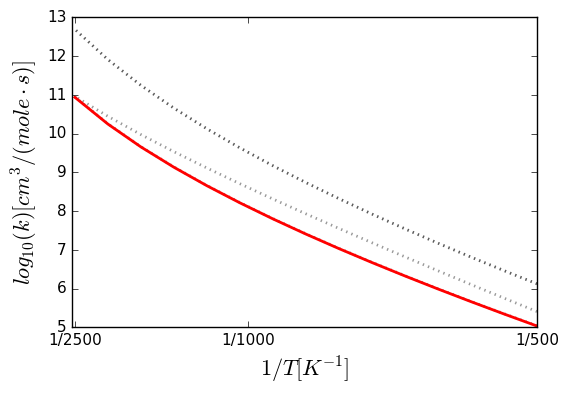

sc4h9oh + ho2 <=> sc4h8oh-3 + h2o2
sc4h9oh + ho2 <=> h2o2 + sc4h8oh-3


(5,)
CCC(C)O+[O]O_OO+[CH2]CC(C)O


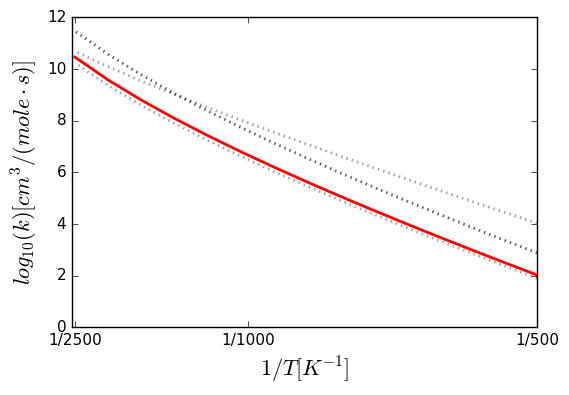

ch2o + ho2 <=> hco + h2o2
ch2o + ho2 <=> h2o2 + hco


(60,)
C=O+[O]O_OO+[CH]=O


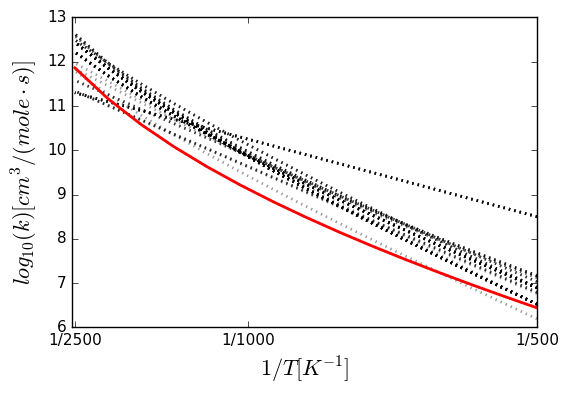

h2o2 + h <=> h2 + ho2
h2o2 + h <=> h2 + ho2


(67,)
OO+[H]_[H][H]+[O]O


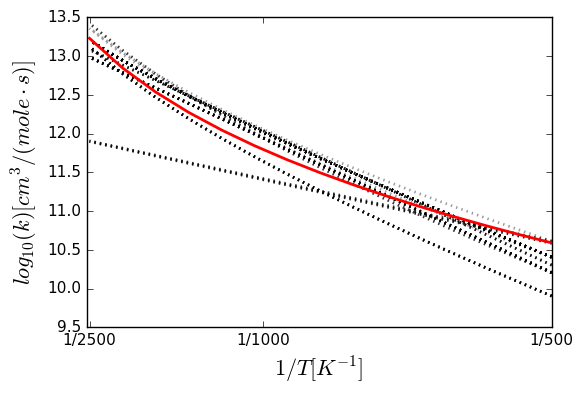

c3h6 + ho2 <=> c3h5-a + h2o2
C3H5-A + H2O2 <=> C3H6 + HO2


(50,)
OO+[CH2]C=C_C=CC+[O]O


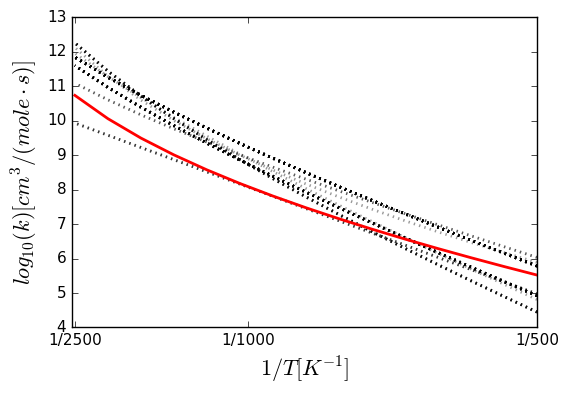

HCO + H2O2 => CH2O + HO2
ch2o + ho2 <=> h2o2 + hco


(4,)
C=O+[O]O_OO+[CH]=O


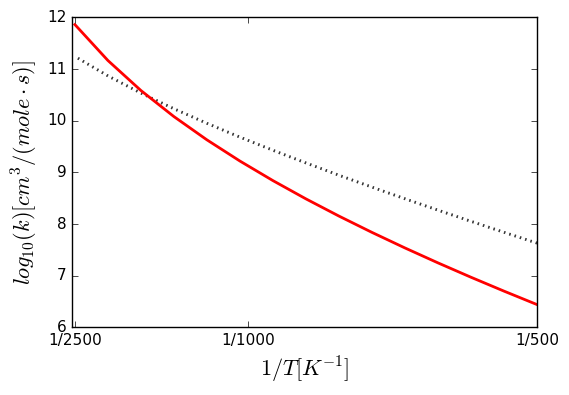

CH2CHCH2 + H2O2 => C3H6 + HO2
C3H5-A + H2O2 <=> C3H6 + HO2


(2,)
OO+[CH2]C=C_C=CC+[O]O


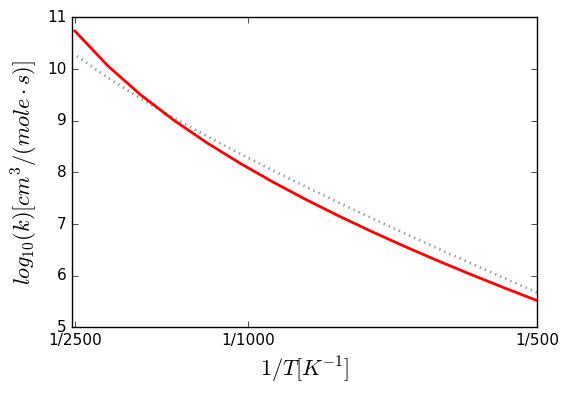

In [31]:
import numpy as np
inverseTemps = np.linspace(1000./500., 1000./2500., 15)
Temps = 1000./inverseTemps

comparisonPressure = 1e5 # Pa
for i, reaction in enumerate(importer_kinetics.columns):
    for autotst_rxn in reactions_df["AutoTST Reaction"]:
        

        
        if reaction.isIsomorphic(autotst_rxn):
            
            print reaction
            print autotst_rxn
            print
            rxn_kinetics = importer_kinetics.iloc[:,i].dropna()

            rxn_kinetics["AutoTST"] = autotst_rxn.kinetics
            
            
            #print rxn_kinetics
            print 
            print rxn_kinetics.shape
            
            
            fig, ax = plt.subplots()
            for index in rxn_kinetics.index:
                logk = []
                logkAutoTST = []
                kinetics = rxn_kinetics[index]

                if index == 'AutoTST':

                    for Temp in Temps:
                        k = kinetics.getRateCoefficient(T=Temp,P=comparisonPressure)
                        logkAutoTST.append(np.log10(k) + 6)

                    plt.plot(inverseTemps, logkAutoTST, '-r', linewidth=2)
                else:
                    for Temp in Temps:
                        k = kinetics.getRateCoefficient(T=Temp,P=comparisonPressure)
                        logk.append(np.log10(k) + 6)
                    plt.plot(inverseTemps, logk, ':k', linewidth=2, alpha=0.4)
            plt.xlabel("$1/T [K^{-1}]$", fontsize=16)
            plt.ylabel("$log_{10}(k) [cm^3 / (mole \cdot s)]$", fontsize=16)
            label = autotst_rxn.label

            Tticks = [500, 1000, 2500]
            ax.set_xticks([1000./T for T in Tticks])
            ax.set_xticklabels(['1/{:.0f}'.format(T) for T in Tticks])
            plt.tick_params(axis='x', labelsize=11)
            plt.tick_params(axis='y', labelsize=11)
            #plt.title(label)
            plt.xlim([0.39,2])

            plt.ylim(max([ax.get_ylim()[0], 0]), min([ax.get_ylim()[1], 15]))
            saveString = os.path.join("../reference_files/", str(autotst_rxn) + '.pdf')
            plt.savefig(saveString)
            print str(label)
            plt.show() 
    


In [ ]:
autotst_rxn

In [ ]:
test_rxn = sarathy_df["AutoTST Reaction"].iloc[0]

In [ ]:
importer_kinetics.T[importer_kinetics.T.index.map(test_rxn.isIsomorphic)].T

h2o2 + h <=> h2 + ho2

OO+[H]_[H][H]+[O]O


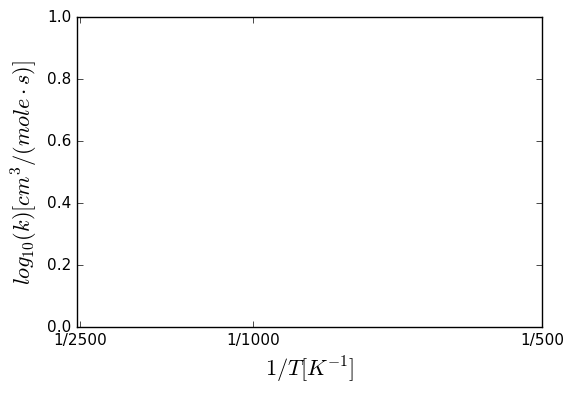

ch2o + ho2 <=> h2o2 + hco

AramcoMech_1.3
nah, we good
AramcoMech_2.0
nah, we good
AutoTST-OOHabstraction
nah, we good
Chernov
nah, we good
CombFlame2012/2028-Sarathy
nah, we good
CombFlame2013/1315-Chang
nah, we good
CombFlame2013/1541-Zhang
nah, we good
CombFlame2013/17-Malewicki
nah, we good
CombFlame2013/1939-Cai
nah, we good
CombFlame2013/1958-Zhao
nah, we good
CombFlame2013/2291-Somers
nah, we good
CombFlame2013/2712-Sarathy
nah, we good
CombFlame2013/487-Schenk
nah, we good
CombFlame2014/1135-Dames
nah, we good
CombFlame2014/405-Cai
nah, we good
CombFlame2014/65-Darcy
nah, we good
CombFlame2014/657-Jin
nah, we good
CombFlame2014/84-Wang
nah, we good
GRI-mech-3.0
nah, we good
Gasoline_2
nah, we good
Gasoline_Surrogate
nah, we good
IJCK2013/638-Metcalfe
nah, we good
MB-Dooley
nah, we good
MB-Farooq
nah, we good
MB-Fisher
nah, we good
Narayanaswamy
nah, we good
PCI2013/225-Somers
nah, we good
PCI2013/259-Labbe
nah, we good
PCI2013/289-Dagaut
(2,)
oh shit
PCI2013/297-Herbinet
nah, w

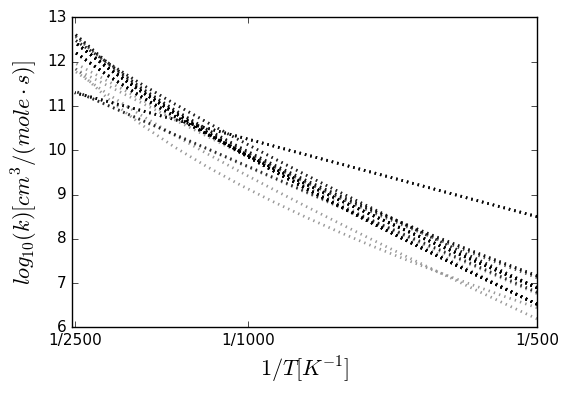

nc4h9oh + ho2 <=> c4h8oh-1 + h2o2

CCCCO+[O]O_CCC[CH]O+OO


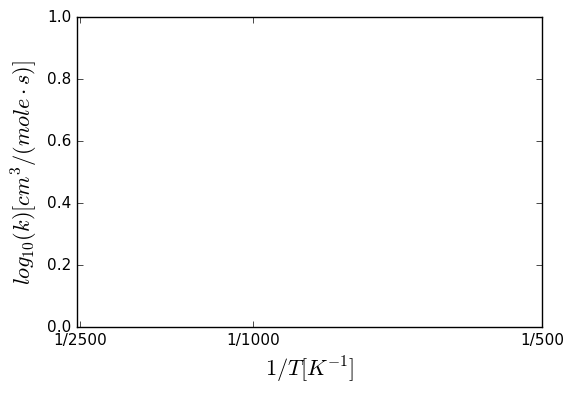

sc4h9oh + ho2 <=> h2o2 + sc4h8oh-3

CCC(C)O+[O]O_OO+[CH2]CC(C)O


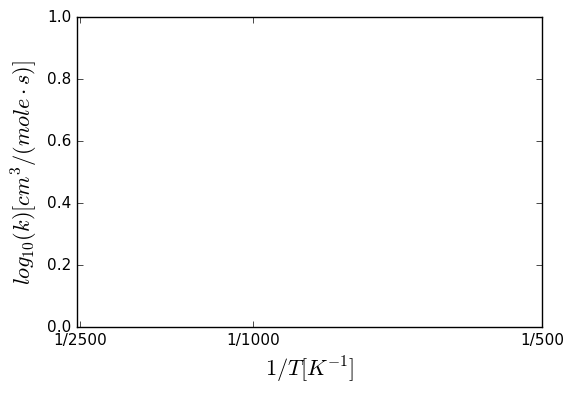

C3H5-A + H2O2 <=> C3H6 + HO2

AramcoMech_1.3
nah, we good
AramcoMech_2.0
nah, we good
AutoTST-OOHabstraction
nah, we good
Chernov
nah, we good
CombFlame2012/2028-Sarathy
nah, we good
CombFlame2013/1541-Zhang
nah, we good
CombFlame2013/17-Malewicki
nah, we good
CombFlame2013/1939-Cai
nah, we good
CombFlame2013/2291-Somers
nah, we good
CombFlame2013/2712-Sarathy
nah, we good
CombFlame2014/1135-Dames
nah, we good
CombFlame2014/405-Cai
nah, we good
CombFlame2014/65-Darcy
nah, we good
CombFlame2014/84-Wang
nah, we good
Gasoline_2
nah, we good
Gasoline_Surrogate
nah, we good
IJCK2013/638-Metcalfe
nah, we good
MB-Dooley
nah, we good
MB-Farooq
nah, we good
MB-Fisher
nah, we good
Narayanaswamy
nah, we good
PCI2013/225-Somers
nah, we good
PCI2013/259-Labbe
nah, we good
PCI2013/289-Dagaut
(2,)
oh shit
PCI2013/297-Herbinet
nah, we good
PCI2013/325-Husson
nah, we good
PCI2013/335-Wang
nah, we good
PCI2013/353-Malewicki
nah, we good
PCI2013/361-Malewicki
nah, we good
PCI2013/401-Liu
nah, we good
PCI

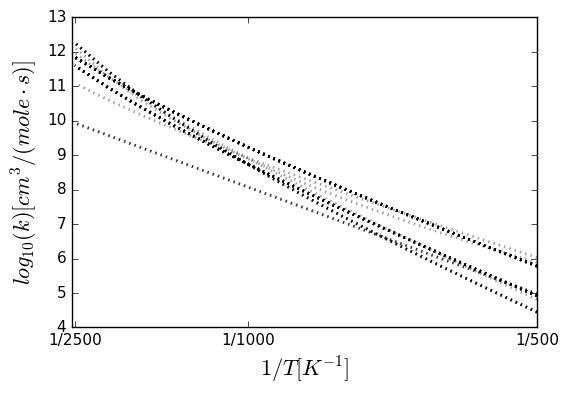

HO2 + NC7H16 <=> C7H15-2 + H2O2

CCCCCCC+[O]O_C[CH]CCCCC+OO


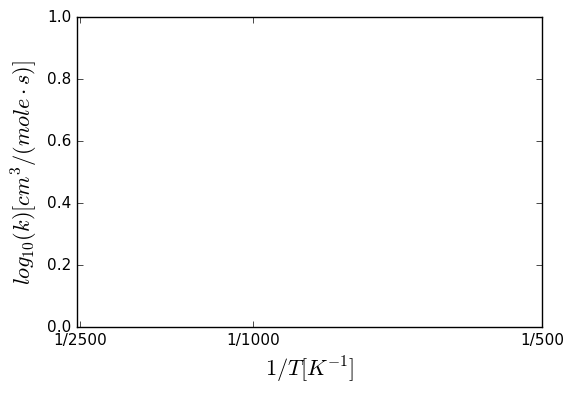

In [146]:
import numpy as np
inverseTemps = np.linspace(1000./500., 1000./2500., 15)
Temps = 1000./inverseTemps

comparisonPressure = 1e5 # Pa
for autotst_rxn in reactions_df["AutoTST Reaction"]:
    print autotst_rxn
    if 1 < importer_kinetics.T[importer_kinetics.columns.map(autotst_rxn.isIsomorphic)].shape[0]:
        a = importer_kinetics.T[importer_kinetics.columns.map(autotst_rxn.isIsomorphic)].iloc[0,:]
        b = importer_kinetics.T[importer_kinetics.columns.map(autotst_rxn.isIsomorphic)].iloc[1,:]

        rxn_kinetics = a.append(b).dropna()
        #rxn_kinetics = pd.DataFrame(pd.concat([a,b]).dropna()).T
    else:
        rxn_kinetics = importer_kinetics.T[importer_kinetics.columns.map(autotst_rxn.isIsomorphic)].dropna()
        
        
    #rxn_kinetics.T["AutoTST"] = autotst_rxn.kinetics

    #print rxn_kinetics
    print 
    #print rxn_kinetics.shape





    fig, ax = plt.subplots()
    for index in rxn_kinetics.index:
        logk = []
        logkAutoTST = []
        kinetics = rxn_kinetics.loc[index]
        print index

        if index == 'AutoTST':

            for Temp in Temps:
                k = kinetics.getRateCoefficient(T=Temp,P=comparisonPressure)
                logkAutoTST.append(np.log10(k) + 6)

            plt.plot(inverseTemps, logkAutoTST, '-r', linewidth=2)
        else:
            try: 
                print rxn_kinetics.loc[index].shape
                print "oh shit"
                continue
                
            except:
                print "nah, we good"
            for Temp in Temps:
                k = kinetics.getRateCoefficient(T=Temp,P=comparisonPressure)
                logk.append(np.log10(k) + 6)
            plt.plot(inverseTemps, logk, ':k', linewidth=2, alpha=0.4)
    plt.xlabel("$1/T [K^{-1}]$", fontsize=16)
    plt.ylabel("$log_{10}(k) [cm^3 / (mole \cdot s)]$", fontsize=16)
    label = autotst_rxn.label

    Tticks = [500, 1000, 2500]
    ax.set_xticks([1000./T for T in Tticks])
    ax.set_xticklabels(['1/{:.0f}'.format(T) for T in Tticks])
    plt.tick_params(axis='x', labelsize=11)
    plt.tick_params(axis='y', labelsize=11)
    #plt.title(label)
    plt.xlim([0.39,2])

    plt.ylim(max([ax.get_ylim()[0], 0]), min([ax.get_ylim()[1], 15]))
    saveString = os.path.join("../reference_files/", str(autotst_rxn) + '.pdf')
    #plt.savefig(saveString)
    print str(label)
    plt.show() 
            
    


In [142]:
rxn_kinetics.loc["PCI2013/289-Dagaut"].shape

(2,)

In [65]:
rxn = reactions_df.iloc[1,1]
rxn

In [72]:
a = importer_kinetics.T[importer_kinetics.columns.map(rxn.isIsomorphic)].T.iloc[:,0]
b = importer_kinetics.T[importer_kinetics.columns.map(rxn.isIsomorphic)].T.iloc[:,1]

In [74]:
pd.concat([a,b]).shape

(148,)

In [79]:
if 1 < importer_kinetics.T[importer_kinetics.columns.map(rxn.isIsomorphic)].T.shape[1]:
    print "oh"

oh


In [100]:
importer_kinetics.T[importer_kinetics.columns.map(autotst_rxn.isIsomorphic)].T.shape[1]

2

In [90]:
kinetics.values[0]

Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea=(6000,'cal/mol'), T0=(1,'K'))

In [98]:
rxn_kinetics.dropna(axis=1)

,AramcoMech_1.3,AramcoMech_2.0,Biomass,Chernov,CombFlame2012/2028-Sarathy,CombFlame2013/1315-Chang,CombFlame2013/1541-Zhang,CombFlame2013/1609-Veloo,CombFlame2013/17-Malewicki,CombFlame2013/1939-Cai,...,PCI2017/052-Stagni,PCI2017/058-Sun,PCI2017/082-Hemken,PCI2017/087-Tran,PCI2017/111-Jin,PCI2017/145-Sun,Shamel-Propane,USC_Mech_ii,n-Heptane,AutoTST
h2o2 + h <=> h2 + ho2,"Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(6.025e+13,'cm^3/(mol*s)'), n=0, E...","Arrhenius(A=(1.69e+12,'cm^3/(mol*s)'), n=0, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(4.82e+13,'cm^3/(mol*s)'), n=0, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(6.05e+06,'cm^3/(mol*s)'), n=2, Ea...","Arrhenius(A=(4.82e+13,'cm^3/(mol*s)'), n=0, Ea...","Arrhenius(A=(6.05e+06,'cm^3/(mol*s)'), n=2, Ea...",...,"Arrhenius(A=(6.025e+13,'cm^3/(mol*s)'), n=0, E...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(4.82e+13,'cm^3/(mol*s)'), n=0, Ea...","Arrhenius(A=(6.05e+06,'cm^3/(mol*s)'), n=2, Ea...","Arrhenius(A=(2.15e+10,'cm^3/(mol*s)'), n=1, Ea...","Arrhenius(A=(165.058,'cm^3/(mol*s)'), n=3.2674..."


In [103]:
pd.concat([a,b]).dropna()

AramcoMech_1.3                          Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
AramcoMech_2.0                          Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
AutoTST-OOHabstraction                  Arrhenius(A=(4.23547e-06,'cm^3/(mol*s)'), n=5....
Chernov                                 Arrhenius(A=(3.01e+12,'cm^3/(mol*s)'), n=0, Ea...
CombFlame2012/2028-Sarathy              Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
CombFlame2013/1315-Chang                Arrhenius(A=(41100,'cm^3/(mol*s)'), n=2.5, Ea=...
CombFlame2013/1541-Zhang                Arrhenius(A=(0.0071,'cm^3/(mol*s)'), n=4.517, ...
CombFlame2013/17-Malewicki              Arrhenius(A=(41100,'cm^3/(mol*s)'), n=2.5, Ea=...
CombFlame2013/1939-Cai                  Arrhenius(A=(1e+12,'cm^3/(mol*s)'), n=0, Ea=(8...
CombFlame2013/1958-Zhao                 Arrhenius(A=(1e+12,'cm^3/(mol*s)'), n=0, Ea=(8...
CombFlame2013/2291-Somers               Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
CombFlame2

In [114]:
pd.concat([a.T,b.T])

ch2o + ho2 <=> hco + h2o2    Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
HCO + H2O2 => CH2O + HO2                                                   NaN
ch2o + ho2 <=> hco + h2o2    Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
HCO + H2O2 => CH2O + HO2                                                   NaN
dtype: object

In [133]:
a = importer_kinetics.T[importer_kinetics.columns.map(autotst_rxn.isIsomorphic)].iloc[0,:]
b = importer_kinetics.T[importer_kinetics.columns.map(autotst_rxn.isIsomorphic)].iloc[1,:]

a.append(b).dropna()

AramcoMech_1.3                          Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
AramcoMech_2.0                          Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
AutoTST-OOHabstraction                  Arrhenius(A=(4.23547e-06,'cm^3/(mol*s)'), n=5....
Chernov                                 Arrhenius(A=(3.01e+12,'cm^3/(mol*s)'), n=0, Ea...
CombFlame2012/2028-Sarathy              Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
CombFlame2013/1315-Chang                Arrhenius(A=(41100,'cm^3/(mol*s)'), n=2.5, Ea=...
CombFlame2013/1541-Zhang                Arrhenius(A=(0.0071,'cm^3/(mol*s)'), n=4.517, ...
CombFlame2013/17-Malewicki              Arrhenius(A=(41100,'cm^3/(mol*s)'), n=2.5, Ea=...
CombFlame2013/1939-Cai                  Arrhenius(A=(1e+12,'cm^3/(mol*s)'), n=0, Ea=(8...
CombFlame2013/1958-Zhao                 Arrhenius(A=(1e+12,'cm^3/(mol*s)'), n=0, Ea=(8...
CombFlame2013/2291-Somers               Arrhenius(A=(18800,'cm^3/(mol*s)'), n=2.7, Ea=...
CombFlame2